# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [303]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

### Task 1: Backpropagation and Simple Training

In [304]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

#set_seed(SEED)

In [305]:
def standard_normalization(x):
    """Default normalization function. Normalizes the input x."""
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    """Compute the moving average of x with window size w."""
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    """Get some random numbers based on Normal Distribution to initialize weights."""
    # Normal distribution initialization
    return torch.randn(input_size, output_size)
    
def xavier_init(input_size, output_size):
    """ Get some random number to initialize weights."""
    # Xavier initialization
    return torch.randn(input_size, output_size) * np.sqrt(2.0/(input_size + output_size))

In [306]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights with standard normal distribution and bias with zeros
        # self.weight = normaldist_init(self.in_channels, self.out_channels)
        
        # Xavier initialization
        self.weight = xavier_init(self.in_channels, self.out_channels)
        self.bias = torch.zeros(self.out_channels)
        
        # store last input for backpropagation
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # reshape input to 2D tensor
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # calculate linear transformation
        newx = torch.matmul(x, self.weight) + self.bias
        return newx
    
    def backward(self, gradient):
        # calculate gradients
        self.grad_weight = torch.matmul(self.last_input.t(), gradient)
        self.grad_bias = torch.sum(gradient, dim=0)
        
        # reshape gradient to original input shape
        if len(self.last_input.shape) > 2:
            gradient = gradient.view(*self.last_input.shape)

        # calculate gradient for previous layer
        newgrad = torch.matmul(gradient, self.weight.t())

        return newgrad

    
    def update(self, learning_rate):
        # update weights and bias
        self.weight -= learning_rate * self.grad_weight
        self.bias -= learning_rate * self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        newx = torch.max(x, torch.zeros_like(x))
        return newx
    
    def backward(self, gradient):
        # ReLU gradient - check where input is larger than zero return 1, else 0
        newgrad = torch.where(self.last_input>0, gradient, 0.0)
        return newgrad
    
    def update(self, learning_rate):
        # we don't have any parameters in ReLU layer here
        # other ReLU activations can have parameters that might need to be learned
        pass
    

In [307]:
class Softmax:
    """ Numerically stable Softmax implementation since we take the max() 
        of the input per samples not per batch. 
        We constrain it into a range of 0 to 1.
    """
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x-torch.amax(x, dim=-1, keepdims=True)) # numerical stable version -> normalize by max(x) over the last dimension
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        # you can use any character, but make sure they are consistent
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [308]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

              

In [309]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [310]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        # loss per epoch
        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            epoch_train_loss += loss.item()

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            epoch_test_loss += loss.item()

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")

        # append average loss for this epoch
        losses_train.append(epoch_train_loss / num_batches_train)
        losses_test.append(epoch_test_loss / num_batches_test)

    return losses_train, losses_test


In [311]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.1, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.1, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [312]:
# 2. Implement missing parts in the training routine

# rescale data (normalise) to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 3e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


100%|██████████| 250/250 [00:00<00:00, 5352.99it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.7572382092475891
Epoch 1/10, Iteration 11/250, Train Loss: 0.18963564932346344
Epoch 1/10, Iteration 21/250, Train Loss: 0.6313353180885315
Epoch 1/10, Iteration 31/250, Train Loss: 0.19454871118068695
Epoch 1/10, Iteration 41/250, Train Loss: 0.27822592854499817
Epoch 1/10, Iteration 51/250, Train Loss: 0.3751060366630554
Epoch 1/10, Iteration 61/250, Train Loss: 0.197788804769516
Epoch 1/10, Iteration 71/250, Train Loss: 0.2115151733160019
Epoch 1/10, Iteration 81/250, Train Loss: 0.19716934859752655
Epoch 1/10, Iteration 91/250, Train Loss: 0.11829347908496857
Epoch 1/10, Iteration 101/250, Train Loss: 0.12358331680297852
Epoch 1/10, Iteration 111/250, Train Loss: 0.01596417836844921
Epoch 1/10, Iteration 121/250, Train Loss: 0.060279060155153275
Epoch 1/10, Iteration 131/250, Train Loss: 0.714499831199646
Epoch 1/10, Iteration 141/250, Train Loss: 0.2963244318962097
Epoch 1/10, Iteration 151/250, Train Loss: 0.2550813853740692
Epoch 1/10, 

100%|██████████| 250/250 [00:00<00:00, 5495.71it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 2.118536949157715
Epoch 2/10, Iteration 11/250, Train Loss: 0.28522032499313354
Epoch 2/10, Iteration 21/250, Train Loss: 0.22237282991409302
Epoch 2/10, Iteration 31/250, Train Loss: 0.24431461095809937
Epoch 2/10, Iteration 41/250, Train Loss: 0.13870152831077576
Epoch 2/10, Iteration 51/250, Train Loss: 0.13445037603378296
Epoch 2/10, Iteration 61/250, Train Loss: 0.084870845079422
Epoch 2/10, Iteration 71/250, Train Loss: 0.20567762851715088
Epoch 2/10, Iteration 81/250, Train Loss: 0.06558242440223694
Epoch 2/10, Iteration 91/250, Train Loss: 0.0124131478369236
Epoch 2/10, Iteration 101/250, Train Loss: 0.010222315788269043
Epoch 2/10, Iteration 111/250, Train Loss: 0.004069781396538019
Epoch 2/10, Iteration 121/250, Train Loss: 0.21699535846710205
Epoch 2/10, Iteration 131/250, Train Loss: 0.028476079925894737
Epoch 2/10, Iteration 141/250, Train Loss: 0.1045701801776886
Epoch 2/10, Iteration 151/250, Train Loss: 0.0292968787252903
Epoch 2

100%|██████████| 250/250 [00:00<00:00, 5388.48it/s]


Epoch 3/10, Iteration 1/250, Train Loss: 0.054144177585840225
Epoch 3/10, Iteration 11/250, Train Loss: 0.019677985459566116
Epoch 3/10, Iteration 21/250, Train Loss: 0.03784418851137161
Epoch 3/10, Iteration 31/250, Train Loss: 0.0031171380542218685
Epoch 3/10, Iteration 41/250, Train Loss: 0.008900795131921768
Epoch 3/10, Iteration 51/250, Train Loss: 0.021198421716690063
Epoch 3/10, Iteration 61/250, Train Loss: 0.0007307366468012333
Epoch 3/10, Iteration 71/250, Train Loss: 0.004853800404816866
Epoch 3/10, Iteration 81/250, Train Loss: 0.010657277889549732
Epoch 3/10, Iteration 91/250, Train Loss: 0.009893913753330708
Epoch 3/10, Iteration 101/250, Train Loss: 0.00018468113557901233
Epoch 3/10, Iteration 111/250, Train Loss: 0.02463848516345024
Epoch 3/10, Iteration 121/250, Train Loss: 0.0006462770397774875
Epoch 3/10, Iteration 131/250, Train Loss: nan
Epoch 3/10, Iteration 141/250, Train Loss: nan
Epoch 3/10, Iteration 151/250, Train Loss: nan
Epoch 3/10, Iteration 161/250, Trai

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: nan
Epoch 4/10, Iteration 11/250, Train Loss: nan
Epoch 4/10, Iteration 21/250, Train Loss: nan
Epoch 4/10, Iteration 31/250, Train Loss: nan
Epoch 4/10, Iteration 41/250, Train Loss: nan
Epoch 4/10, Iteration 51/250, Train Loss: nan
Epoch 4/10, Iteration 61/250, Train Loss: nan
Epoch 4/10, Iteration 71/250, Train Loss: nan
Epoch 4/10, Iteration 81/250, Train Loss: nan
Epoch 4/10, Iteration 91/250, Train Loss: nan
Epoch 4/10, Iteration 101/250, Train Loss: nan
Epoch 4/10, Iteration 111/250, Train Loss: nan
Epoch 4/10, Iteration 121/250, Train Loss: nan
Epoch 4/10, Iteration 131/250, Train Loss: nan
Epoch 4/10, Iteration 141/250, Train Loss: nan
Epoch 4/10, Iteration 151/250, Train Loss: nan
Epoch 4/10, Iteration 161/250, Train Loss: nan
Epoch 4/10, Iteration 171/250, Train Loss: nan
Epoch 4/10, Iteration 181/250, Train Loss: nan
Epoch 4/10, Iteration 191/250, Train Loss: nan
Epoch 4/10, Iteration 201/250, Train Loss: nan
Epoch 4/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5221.81it/s]


Epoch 4/10, Iteration 1/63, Test Loss: nan
Epoch 4/10, Iteration 11/63, Test Loss: nan
Epoch 4/10, Iteration 21/63, Test Loss: nan
Epoch 4/10, Iteration 31/63, Test Loss: nan
Epoch 4/10, Iteration 41/63, Test Loss: nan
Epoch 4/10, Iteration 51/63, Test Loss: nan
Epoch 4/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: nan
Epoch 5/10, Iteration 11/250, Train Loss: nan
Epoch 5/10, Iteration 21/250, Train Loss: nan
Epoch 5/10, Iteration 31/250, Train Loss: nan
Epoch 5/10, Iteration 41/250, Train Loss: nan
Epoch 5/10, Iteration 51/250, Train Loss: nan
Epoch 5/10, Iteration 61/250, Train Loss: nan
Epoch 5/10, Iteration 71/250, Train Loss: nan
Epoch 5/10, Iteration 81/250, Train Loss: nan
Epoch 5/10, Iteration 91/250, Train Loss: nan
Epoch 5/10, Iteration 101/250, Train Loss: nan
Epoch 5/10, Iteration 111/250, Train Loss: nan
Epoch 5/10, Iteration 121/250, Train Loss: nan
Epoch 5/10, Iteration 131/250, Train Loss: nan
Epoch 5/10, Iteration 141/250, Train Loss: nan
Epoch 5/10, Iteration 151/250, Train Loss: nan
Epoch 5/10, Iteration 161/250, Train Loss: nan
Epoch 5/10, Iteration 171/250, Train Loss: nan
Epoch 5/10, Iteration 181/250, Train Loss: nan
Epoch 5/10, Iteration 191/250, Train Loss: nan
Epoch 5/10, Iteration 201/250, Train Loss: nan
Epoch 5/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5011.91it/s]


Epoch 5/10, Iteration 241/250, Train Loss: nan
Epoch 5/10, Iteration 1/63, Test Loss: nan
Epoch 5/10, Iteration 11/63, Test Loss: nan
Epoch 5/10, Iteration 21/63, Test Loss: nan
Epoch 5/10, Iteration 31/63, Test Loss: nan
Epoch 5/10, Iteration 41/63, Test Loss: nan
Epoch 5/10, Iteration 51/63, Test Loss: nan
Epoch 5/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: nan
Epoch 6/10, Iteration 11/250, Train Loss: nan
Epoch 6/10, Iteration 21/250, Train Loss: nan
Epoch 6/10, Iteration 31/250, Train Loss: nan
Epoch 6/10, Iteration 41/250, Train Loss: nan
Epoch 6/10, Iteration 51/250, Train Loss: nan
Epoch 6/10, Iteration 61/250, Train Loss: nan
Epoch 6/10, Iteration 71/250, Train Loss: nan
Epoch 6/10, Iteration 81/250, Train Loss: nan
Epoch 6/10, Iteration 91/250, Train Loss: nan
Epoch 6/10, Iteration 101/250, Train Loss: nan
Epoch 6/10, Iteration 111/250, Train Loss: nan
Epoch 6/10, Iteration 121/250, Train Loss: nan
Epoch 6/10, Iteration 131/250, Train Loss: nan
Epoch 6/10, Iteration 141/250, Train Loss: nan
Epoch 6/10, Iteration 151/250, Train Loss: nan
Epoch 6/10, Iteration 161/250, Train Loss: nan
Epoch 6/10, Iteration 171/250, Train Loss: nan
Epoch 6/10, Iteration 181/250, Train Loss: nan
Epoch 6/10, Iteration 191/250, Train Loss: nan
Epoch 6/10, Iteration 201/250, Train Loss: nan
Epoch 6/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5245.69it/s]


Epoch 6/10, Iteration 231/250, Train Loss: nan
Epoch 6/10, Iteration 241/250, Train Loss: nan
Epoch 6/10, Iteration 1/63, Test Loss: nan
Epoch 6/10, Iteration 11/63, Test Loss: nan
Epoch 6/10, Iteration 21/63, Test Loss: nan
Epoch 6/10, Iteration 31/63, Test Loss: nan
Epoch 6/10, Iteration 41/63, Test Loss: nan
Epoch 6/10, Iteration 51/63, Test Loss: nan
Epoch 6/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: nan
Epoch 7/10, Iteration 11/250, Train Loss: nan
Epoch 7/10, Iteration 21/250, Train Loss: nan
Epoch 7/10, Iteration 31/250, Train Loss: nan
Epoch 7/10, Iteration 41/250, Train Loss: nan
Epoch 7/10, Iteration 51/250, Train Loss: nan
Epoch 7/10, Iteration 61/250, Train Loss: nan
Epoch 7/10, Iteration 71/250, Train Loss: nan
Epoch 7/10, Iteration 81/250, Train Loss: nan
Epoch 7/10, Iteration 91/250, Train Loss: nan
Epoch 7/10, Iteration 101/250, Train Loss: nan
Epoch 7/10, Iteration 111/250, Train Loss: nan
Epoch 7/10, Iteration 121/250, Train Loss: nan
Epoch 7/10, Iteration 131/250, Train Loss: nan
Epoch 7/10, Iteration 141/250, Train Loss: nan
Epoch 7/10, Iteration 151/250, Train Loss: nan
Epoch 7/10, Iteration 161/250, Train Loss: nan
Epoch 7/10, Iteration 171/250, Train Loss: nan
Epoch 7/10, Iteration 181/250, Train Loss: nan
Epoch 7/10, Iteration 191/250, Train Loss: nan
Epoch 7/10, Iteration 201/250, Train Loss: nan
Epoch 7/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5361.80it/s]


Epoch 7/10, Iteration 221/250, Train Loss: nan
Epoch 7/10, Iteration 231/250, Train Loss: nan
Epoch 7/10, Iteration 241/250, Train Loss: nan
Epoch 7/10, Iteration 1/63, Test Loss: nan
Epoch 7/10, Iteration 11/63, Test Loss: nan
Epoch 7/10, Iteration 21/63, Test Loss: nan
Epoch 7/10, Iteration 31/63, Test Loss: nan
Epoch 7/10, Iteration 41/63, Test Loss: nan
Epoch 7/10, Iteration 51/63, Test Loss: nan
Epoch 7/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: nan
Epoch 8/10, Iteration 11/250, Train Loss: nan
Epoch 8/10, Iteration 21/250, Train Loss: nan
Epoch 8/10, Iteration 31/250, Train Loss: nan
Epoch 8/10, Iteration 41/250, Train Loss: nan
Epoch 8/10, Iteration 51/250, Train Loss: nan
Epoch 8/10, Iteration 61/250, Train Loss: nan
Epoch 8/10, Iteration 71/250, Train Loss: nan
Epoch 8/10, Iteration 81/250, Train Loss: nan
Epoch 8/10, Iteration 91/250, Train Loss: nan
Epoch 8/10, Iteration 101/250, Train Loss: nan
Epoch 8/10, Iteration 111/250, Train Loss: nan
Epoch 8/10, Iteration 121/250, Train Loss: nan
Epoch 8/10, Iteration 131/250, Train Loss: nan
Epoch 8/10, Iteration 141/250, Train Loss: nan
Epoch 8/10, Iteration 151/250, Train Loss: nan
Epoch 8/10, Iteration 161/250, Train Loss: nan
Epoch 8/10, Iteration 171/250, Train Loss: nan
Epoch 8/10, Iteration 181/250, Train Loss: nan
Epoch 8/10, Iteration 191/250, Train Loss: nan
Epoch 8/10, Iteration 201/250, Train Loss: nan
Epoch 8/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5194.26it/s]


Epoch 8/10, Iteration 231/250, Train Loss: nan
Epoch 8/10, Iteration 241/250, Train Loss: nan
Epoch 8/10, Iteration 1/63, Test Loss: nan
Epoch 8/10, Iteration 11/63, Test Loss: nan
Epoch 8/10, Iteration 21/63, Test Loss: nan
Epoch 8/10, Iteration 31/63, Test Loss: nan
Epoch 8/10, Iteration 41/63, Test Loss: nan
Epoch 8/10, Iteration 51/63, Test Loss: nan
Epoch 8/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: nan
Epoch 9/10, Iteration 11/250, Train Loss: nan
Epoch 9/10, Iteration 21/250, Train Loss: nan
Epoch 9/10, Iteration 31/250, Train Loss: nan
Epoch 9/10, Iteration 41/250, Train Loss: nan
Epoch 9/10, Iteration 51/250, Train Loss: nan
Epoch 9/10, Iteration 61/250, Train Loss: nan
Epoch 9/10, Iteration 71/250, Train Loss: nan
Epoch 9/10, Iteration 81/250, Train Loss: nan
Epoch 9/10, Iteration 91/250, Train Loss: nan
Epoch 9/10, Iteration 101/250, Train Loss: nan
Epoch 9/10, Iteration 111/250, Train Loss: nan
Epoch 9/10, Iteration 121/250, Train Loss: nan
Epoch 9/10, Iteration 131/250, Train Loss: nan
Epoch 9/10, Iteration 141/250, Train Loss: nan
Epoch 9/10, Iteration 151/250, Train Loss: nan
Epoch 9/10, Iteration 161/250, Train Loss: nan
Epoch 9/10, Iteration 171/250, Train Loss: nan
Epoch 9/10, Iteration 181/250, Train Loss: nan
Epoch 9/10, Iteration 191/250, Train Loss: nan
Epoch 9/10, Iteration 201/250, Train Loss: nan
Epoch 9/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5336.51it/s]


Epoch 9/10, Iteration 241/250, Train Loss: nan
Epoch 9/10, Iteration 1/63, Test Loss: nan
Epoch 9/10, Iteration 11/63, Test Loss: nan
Epoch 9/10, Iteration 21/63, Test Loss: nan
Epoch 9/10, Iteration 31/63, Test Loss: nan
Epoch 9/10, Iteration 41/63, Test Loss: nan
Epoch 9/10, Iteration 51/63, Test Loss: nan
Epoch 9/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: nan
Epoch 10/10, Iteration 11/250, Train Loss: nan
Epoch 10/10, Iteration 21/250, Train Loss: nan
Epoch 10/10, Iteration 31/250, Train Loss: nan
Epoch 10/10, Iteration 41/250, Train Loss: nan
Epoch 10/10, Iteration 51/250, Train Loss: nan
Epoch 10/10, Iteration 61/250, Train Loss: nan
Epoch 10/10, Iteration 71/250, Train Loss: nan
Epoch 10/10, Iteration 81/250, Train Loss: nan
Epoch 10/10, Iteration 91/250, Train Loss: nan
Epoch 10/10, Iteration 101/250, Train Loss: nan
Epoch 10/10, Iteration 111/250, Train Loss: nan
Epoch 10/10, Iteration 121/250, Train Loss: nan
Epoch 10/10, Iteration 131/250, Train Loss: nan
Epoch 10/10, Iteration 141/250, Train Loss: nan
Epoch 10/10, Iteration 151/250, Train Loss: nan
Epoch 10/10, Iteration 161/250, Train Loss: nan
Epoch 10/10, Iteration 171/250, Train Loss: nan
Epoch 10/10, Iteration 181/250, Train Loss: nan
Epoch 10/10, Iteration 191/250, Train Loss: nan
Epoch 10/10, Iteration 201/250, Train Loss: nan
Epo

100%|██████████| 250/250 [00:00<00:00, 5398.05it/s]

Epoch 10/10, Iteration 1/63, Test Loss: nan
Epoch 10/10, Iteration 11/63, Test Loss: nan
Epoch 10/10, Iteration 21/63, Test Loss: nan
Epoch 10/10, Iteration 31/63, Test Loss: nan
Epoch 10/10, Iteration 41/63, Test Loss: nan
Epoch 10/10, Iteration 51/63, Test Loss: nan
Epoch 10/10, Iteration 61/63, Test Loss: nan


In [313]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_train, label="Training Loss", marker='o', markersize=4, linestyle='-', color='blue')
    plt.plot(losses_test, label="Testing Loss", marker='o', markersize=4, linestyle='-', color='red')
    plt.title("Loss Curves for Training and Testing Sets", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)

    # store plot in results folder
    # check if folder exists, if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()


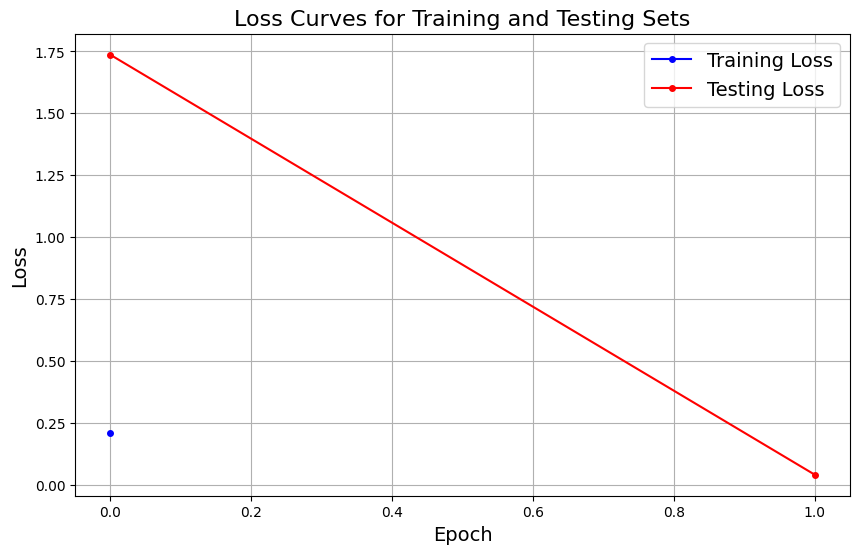

In [314]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_2")

In [315]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 3e-2

hidden_channels = [30, 40, 50, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

100%|██████████| 250/250 [00:00<00:00, 3281.87it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6933261156082153
Epoch 1/10, Iteration 11/250, Train Loss: 13.444454193115234
Epoch 1/10, Iteration 21/250, Train Loss: 0.7319121360778809
Epoch 1/10, Iteration 31/250, Train Loss: 0.7445780038833618
Epoch 1/10, Iteration 41/250, Train Loss: 0.7093339562416077
Epoch 1/10, Iteration 51/250, Train Loss: 0.6989718079566956
Epoch 1/10, Iteration 61/250, Train Loss: 0.6931549310684204
Epoch 1/10, Iteration 71/250, Train Loss: 0.7061084508895874
Epoch 1/10, Iteration 81/250, Train Loss: 0.7071031332015991
Epoch 1/10, Iteration 91/250, Train Loss: 0.749860942363739
Epoch 1/10, Iteration 101/250, Train Loss: 0.6778154373168945
Epoch 1/10, Iteration 111/250, Train Loss: 0.7289730906486511
Epoch 1/10, Iteration 121/250, Train Loss: 0.718793511390686
Epoch 1/10, Iteration 131/250, Train Loss: 0.7119734883308411
Epoch 1/10, Iteration 141/250, Train Loss: 0.6990020275115967
Epoch 1/10, Iteration 151/250, Train Loss: 0.7095447778701782
Epoch 1/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 3141.70it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.7380371689796448
Epoch 2/10, Iteration 11/250, Train Loss: 0.6901577115058899
Epoch 2/10, Iteration 21/250, Train Loss: 0.7219406962394714
Epoch 2/10, Iteration 31/250, Train Loss: 0.6912039518356323
Epoch 2/10, Iteration 41/250, Train Loss: 0.7643406987190247
Epoch 2/10, Iteration 51/250, Train Loss: 0.7083680629730225
Epoch 2/10, Iteration 61/250, Train Loss: 0.6913432478904724
Epoch 2/10, Iteration 71/250, Train Loss: 0.7797545194625854
Epoch 2/10, Iteration 81/250, Train Loss: 0.6885318756103516
Epoch 2/10, Iteration 91/250, Train Loss: 0.6434961557388306
Epoch 2/10, Iteration 101/250, Train Loss: 0.7395216226577759
Epoch 2/10, Iteration 111/250, Train Loss: 0.6950824856758118
Epoch 2/10, Iteration 121/250, Train Loss: 0.7705963253974915
Epoch 2/10, Iteration 131/250, Train Loss: 0.7020066380500793
Epoch 2/10, Iteration 141/250, Train Loss: 0.6888900995254517
Epoch 2/10, Iteration 151/250, Train Loss: 0.6911957859992981
Epoch 2/10, Iterati

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.7027928233146667
Epoch 3/10, Iteration 11/250, Train Loss: 0.6873239874839783
Epoch 3/10, Iteration 21/250, Train Loss: 0.6923442482948303
Epoch 3/10, Iteration 31/250, Train Loss: 0.6950968503952026
Epoch 3/10, Iteration 41/250, Train Loss: 0.6825816035270691
Epoch 3/10, Iteration 51/250, Train Loss: 0.7068713307380676
Epoch 3/10, Iteration 61/250, Train Loss: 0.6977680921554565
Epoch 3/10, Iteration 71/250, Train Loss: 0.695219874382019
Epoch 3/10, Iteration 81/250, Train Loss: 0.6912628412246704
Epoch 3/10, Iteration 91/250, Train Loss: 0.7091491222381592
Epoch 3/10, Iteration 101/250, Train Loss: 0.6921340227127075


100%|██████████| 250/250 [00:00<00:00, 3234.66it/s]


Epoch 3/10, Iteration 111/250, Train Loss: 0.7375335693359375
Epoch 3/10, Iteration 121/250, Train Loss: 0.6895173788070679
Epoch 3/10, Iteration 131/250, Train Loss: 0.701295793056488
Epoch 3/10, Iteration 141/250, Train Loss: 0.765612781047821
Epoch 3/10, Iteration 151/250, Train Loss: 0.6980708241462708
Epoch 3/10, Iteration 161/250, Train Loss: 0.6912814974784851
Epoch 3/10, Iteration 171/250, Train Loss: 0.8096153736114502
Epoch 3/10, Iteration 181/250, Train Loss: 0.7344868183135986
Epoch 3/10, Iteration 191/250, Train Loss: 0.8026636242866516
Epoch 3/10, Iteration 201/250, Train Loss: 0.6972849369049072
Epoch 3/10, Iteration 211/250, Train Loss: 0.6526835560798645
Epoch 3/10, Iteration 221/250, Train Loss: 0.7083079814910889
Epoch 3/10, Iteration 231/250, Train Loss: 0.6647050380706787
Epoch 3/10, Iteration 241/250, Train Loss: 0.7005772590637207
Epoch 3/10, Iteration 1/63, Test Loss: 0.7670739889144897
Epoch 3/10, Iteration 11/63, Test Loss: 0.8288564682006836
Epoch 3/10, Itera

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.684697151184082
Epoch 4/10, Iteration 11/250, Train Loss: 0.6875938177108765
Epoch 4/10, Iteration 21/250, Train Loss: 0.7042348384857178
Epoch 4/10, Iteration 31/250, Train Loss: 0.7555382251739502
Epoch 4/10, Iteration 41/250, Train Loss: 0.6973047256469727
Epoch 4/10, Iteration 51/250, Train Loss: 0.7608730792999268
Epoch 4/10, Iteration 61/250, Train Loss: 0.6756064891815186
Epoch 4/10, Iteration 71/250, Train Loss: 0.7567191123962402
Epoch 4/10, Iteration 81/250, Train Loss: 0.6788936257362366
Epoch 4/10, Iteration 91/250, Train Loss: 0.6870517730712891


100%|██████████| 250/250 [00:00<00:00, 3233.65it/s]


Epoch 4/10, Iteration 101/250, Train Loss: 0.7088228464126587
Epoch 4/10, Iteration 111/250, Train Loss: 0.9204767346382141
Epoch 4/10, Iteration 121/250, Train Loss: 0.7005170583724976
Epoch 4/10, Iteration 131/250, Train Loss: 0.7791085243225098
Epoch 4/10, Iteration 141/250, Train Loss: 0.6912479996681213
Epoch 4/10, Iteration 151/250, Train Loss: 0.7463228702545166
Epoch 4/10, Iteration 161/250, Train Loss: 0.7377453446388245
Epoch 4/10, Iteration 171/250, Train Loss: 0.7198455333709717
Epoch 4/10, Iteration 181/250, Train Loss: 0.9034419059753418
Epoch 4/10, Iteration 191/250, Train Loss: 0.7068381309509277
Epoch 4/10, Iteration 201/250, Train Loss: 0.6695849299430847
Epoch 4/10, Iteration 211/250, Train Loss: 0.6940772533416748
Epoch 4/10, Iteration 221/250, Train Loss: 0.6533697843551636
Epoch 4/10, Iteration 231/250, Train Loss: 0.7068264484405518
Epoch 4/10, Iteration 241/250, Train Loss: 0.7439101934432983
Epoch 4/10, Iteration 1/63, Test Loss: 0.6983033418655396
Epoch 4/10, 

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.7097100615501404
Epoch 5/10, Iteration 11/250, Train Loss: 0.6843920946121216
Epoch 5/10, Iteration 21/250, Train Loss: 0.6924024224281311
Epoch 5/10, Iteration 31/250, Train Loss: 0.6966790556907654
Epoch 5/10, Iteration 41/250, Train Loss: 0.6937673687934875
Epoch 5/10, Iteration 51/250, Train Loss: 0.7337794303894043
Epoch 5/10, Iteration 61/250, Train Loss: 0.6775603890419006
Epoch 5/10, Iteration 71/250, Train Loss: 0.6895517110824585
Epoch 5/10, Iteration 81/250, Train Loss: 0.7076708078384399
Epoch 5/10, Iteration 91/250, Train Loss: 0.6876099109649658
Epoch 5/10, Iteration 101/250, Train Loss: 0.7193114161491394
Epoch 5/10, Iteration 111/250, Train Loss: 0.7097805738449097
Epoch 5/10, Iteration 121/250, Train Loss: 0.6709253787994385
Epoch 5/10, Iteration 131/250, Train Loss: 0.7434879541397095
Epoch 5/10, Iteration 141/250, Train Loss: 0.6710843443870544
Epoch 5/10, Iteration 151/250, Train Loss: 0.710460364818573
Epoch 5/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 3190.24it/s]


Epoch 5/10, Iteration 231/250, Train Loss: 0.7367038726806641
Epoch 5/10, Iteration 241/250, Train Loss: 0.7071266770362854
Epoch 5/10, Iteration 1/63, Test Loss: 0.6980549097061157
Epoch 5/10, Iteration 11/63, Test Loss: 0.7083010673522949
Epoch 5/10, Iteration 21/63, Test Loss: 0.6878087520599365
Epoch 5/10, Iteration 31/63, Test Loss: 0.7083010673522949
Epoch 5/10, Iteration 41/63, Test Loss: 0.6809779405593872
Epoch 5/10, Iteration 51/63, Test Loss: 0.6878086924552917
Epoch 5/10, Iteration 61/63, Test Loss: 0.698054850101471


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.6843933463096619
Epoch 6/10, Iteration 11/250, Train Loss: 0.7203379273414612
Epoch 6/10, Iteration 21/250, Train Loss: 0.6912623047828674
Epoch 6/10, Iteration 31/250, Train Loss: 0.6884090304374695
Epoch 6/10, Iteration 41/250, Train Loss: 0.7115908265113831
Epoch 6/10, Iteration 51/250, Train Loss: 0.6867309212684631
Epoch 6/10, Iteration 61/250, Train Loss: 0.7529709339141846
Epoch 6/10, Iteration 71/250, Train Loss: 0.6647244691848755
Epoch 6/10, Iteration 81/250, Train Loss: 0.7248086929321289
Epoch 6/10, Iteration 91/250, Train Loss: 0.7082983255386353
Epoch 6/10, Iteration 101/250, Train Loss: 0.6891029477119446
Epoch 6/10, Iteration 111/250, Train Loss: 0.6789088845252991
Epoch 6/10, Iteration 121/250, Train Loss: 0.7006003856658936
Epoch 6/10, Iteration 131/250, Train Loss: 0.6946460008621216
Epoch 6/10, Iteration 141/250, Train Loss: 0.7507350444793701
Epoch 6/10, Iteration 151/250, Train Loss: 0.7245790362358093
Epoch 6/10, Iterati

100%|██████████| 250/250 [00:00<00:00, 3229.60it/s]


Epoch 6/10, Iteration 221/250, Train Loss: 0.7069519758224487
Epoch 6/10, Iteration 231/250, Train Loss: 0.6965187191963196
Epoch 6/10, Iteration 241/250, Train Loss: 0.696595311164856
Epoch 6/10, Iteration 1/63, Test Loss: 0.7546032667160034
Epoch 6/10, Iteration 11/63, Test Loss: 0.8099817037582397
Epoch 6/10, Iteration 21/63, Test Loss: 0.6992248296737671
Epoch 6/10, Iteration 31/63, Test Loss: 0.8099817037582397
Epoch 6/10, Iteration 41/63, Test Loss: 0.6623058915138245
Epoch 6/10, Iteration 51/63, Test Loss: 0.6992248296737671
Epoch 6/10, Iteration 61/63, Test Loss: 0.7546032667160034


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.7546033263206482
Epoch 7/10, Iteration 11/250, Train Loss: 0.7001013159751892
Epoch 7/10, Iteration 21/250, Train Loss: 0.6641441583633423
Epoch 7/10, Iteration 31/250, Train Loss: 0.7000402808189392
Epoch 7/10, Iteration 41/250, Train Loss: 0.7535053491592407
Epoch 7/10, Iteration 51/250, Train Loss: 0.6972411870956421
Epoch 7/10, Iteration 61/250, Train Loss: 0.6925200819969177
Epoch 7/10, Iteration 71/250, Train Loss: 0.7663401365280151
Epoch 7/10, Iteration 81/250, Train Loss: 0.7224981784820557
Epoch 7/10, Iteration 91/250, Train Loss: 0.6976878643035889
Epoch 7/10, Iteration 101/250, Train Loss: 0.7290049195289612
Epoch 7/10, Iteration 111/250, Train Loss: 0.7391335368156433
Epoch 7/10, Iteration 121/250, Train Loss: 0.661713719367981
Epoch 7/10, Iteration 131/250, Train Loss: 0.6976336240768433
Epoch 7/10, Iteration 141/250, Train Loss: 0.8209966421127319
Epoch 7/10, Iteration 151/250, Train Loss: 0.6932160258293152
Epoch 7/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 3288.31it/s]


Epoch 7/10, Iteration 231/250, Train Loss: 0.7085672616958618
Epoch 7/10, Iteration 241/250, Train Loss: 0.6853518486022949
Epoch 7/10, Iteration 1/63, Test Loss: 0.6940822601318359
Epoch 7/10, Iteration 11/63, Test Loss: 0.6966140270233154
Epoch 7/10, Iteration 21/63, Test Loss: 0.6915505528450012
Epoch 7/10, Iteration 31/63, Test Loss: 0.6966140270233154
Epoch 7/10, Iteration 41/63, Test Loss: 0.6898627281188965
Epoch 7/10, Iteration 51/63, Test Loss: 0.6915505528450012
Epoch 7/10, Iteration 61/63, Test Loss: 0.6940822601318359


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.6949261426925659
Epoch 8/10, Iteration 11/250, Train Loss: 0.6818049550056458
Epoch 8/10, Iteration 21/250, Train Loss: 0.7057415843009949
Epoch 8/10, Iteration 31/250, Train Loss: 0.7062150239944458
Epoch 8/10, Iteration 41/250, Train Loss: 0.7290129065513611
Epoch 8/10, Iteration 51/250, Train Loss: 0.8466611504554749
Epoch 8/10, Iteration 61/250, Train Loss: 0.6912727355957031
Epoch 8/10, Iteration 71/250, Train Loss: 0.6838095784187317
Epoch 8/10, Iteration 81/250, Train Loss: 0.8029456734657288
Epoch 8/10, Iteration 91/250, Train Loss: 0.6853458881378174
Epoch 8/10, Iteration 101/250, Train Loss: 0.6975985765457153
Epoch 8/10, Iteration 111/250, Train Loss: 0.680929958820343
Epoch 8/10, Iteration 121/250, Train Loss: 0.6980093717575073
Epoch 8/10, Iteration 131/250, Train Loss: 0.7200428247451782
Epoch 8/10, Iteration 141/250, Train Loss: 0.6969343423843384
Epoch 8/10, Iteration 151/250, Train Loss: 0.6912043690681458
Epoch 8/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 3248.75it/s]


Epoch 8/10, Iteration 231/250, Train Loss: 0.7115570306777954
Epoch 8/10, Iteration 241/250, Train Loss: 0.6982942223548889
Epoch 8/10, Iteration 1/63, Test Loss: 0.6989697813987732
Epoch 8/10, Iteration 11/63, Test Loss: 0.7106351256370544
Epoch 8/10, Iteration 21/63, Test Loss: 0.6873043775558472
Epoch 8/10, Iteration 31/63, Test Loss: 0.7106351256370544
Epoch 8/10, Iteration 41/63, Test Loss: 0.6795275211334229
Epoch 8/10, Iteration 51/63, Test Loss: 0.6873044371604919
Epoch 8/10, Iteration 61/63, Test Loss: 0.6989697813987732


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.6950812935829163
Epoch 9/10, Iteration 11/250, Train Loss: 0.6079959869384766
Epoch 9/10, Iteration 21/250, Train Loss: 0.6912034749984741
Epoch 9/10, Iteration 31/250, Train Loss: 0.6992292404174805
Epoch 9/10, Iteration 41/250, Train Loss: 0.692373514175415
Epoch 9/10, Iteration 51/250, Train Loss: 0.6853194832801819
Epoch 9/10, Iteration 61/250, Train Loss: 0.6776712536811829
Epoch 9/10, Iteration 71/250, Train Loss: 0.6930103302001953
Epoch 9/10, Iteration 81/250, Train Loss: 0.7020119428634644
Epoch 9/10, Iteration 91/250, Train Loss: 0.6937212944030762
Epoch 9/10, Iteration 101/250, Train Loss: 0.6617327928543091
Epoch 9/10, Iteration 111/250, Train Loss: 0.6941929459571838
Epoch 9/10, Iteration 121/250, Train Loss: 0.7346051335334778
Epoch 9/10, Iteration 131/250, Train Loss: 0.7295577526092529
Epoch 9/10, Iteration 141/250, Train Loss: 0.7029025554656982
Epoch 9/10, Iteration 151/250, Train Loss: 0.6947570443153381
Epoch 9/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 3280.10it/s]


Epoch 9/10, Iteration 241/250, Train Loss: 0.6632779836654663
Epoch 9/10, Iteration 1/63, Test Loss: 0.6927128434181213
Epoch 9/10, Iteration 11/63, Test Loss: 0.6706060171127319
Epoch 9/10, Iteration 21/63, Test Loss: 0.7148195505142212
Epoch 9/10, Iteration 31/63, Test Loss: 0.6706060171127319
Epoch 9/10, Iteration 41/63, Test Loss: 0.7295573949813843
Epoch 9/10, Iteration 51/63, Test Loss: 0.714819610118866
Epoch 9/10, Iteration 61/63, Test Loss: 0.6927127838134766


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.7148195505142212
Epoch 10/10, Iteration 11/250, Train Loss: 0.7013659477233887
Epoch 10/10, Iteration 21/250, Train Loss: 0.6853145360946655
Epoch 10/10, Iteration 31/250, Train Loss: 0.7097491025924683
Epoch 10/10, Iteration 41/250, Train Loss: 0.6925456523895264
Epoch 10/10, Iteration 51/250, Train Loss: 0.6464877128601074
Epoch 10/10, Iteration 61/250, Train Loss: 0.662185549736023
Epoch 10/10, Iteration 71/250, Train Loss: 0.692175030708313
Epoch 10/10, Iteration 81/250, Train Loss: 0.693548321723938
Epoch 10/10, Iteration 91/250, Train Loss: 0.6699672937393188
Epoch 10/10, Iteration 101/250, Train Loss: 0.7213654518127441
Epoch 10/10, Iteration 111/250, Train Loss: 0.7762398719787598
Epoch 10/10, Iteration 121/250, Train Loss: 0.7627260684967041
Epoch 10/10, Iteration 131/250, Train Loss: 0.6984114050865173
Epoch 10/10, Iteration 141/250, Train Loss: 0.6830319166183472
Epoch 10/10, Iteration 151/250, Train Loss: 0.6925625801086426
Epoch 

100%|██████████| 250/250 [00:00<00:00, 2953.72it/s]

Epoch 10/10, Iteration 221/250, Train Loss: 0.7028319835662842
Epoch 10/10, Iteration 231/250, Train Loss: 0.7178771495819092
Epoch 10/10, Iteration 241/250, Train Loss: 0.6853192448616028
Epoch 10/10, Iteration 1/63, Test Loss: 0.691274106502533
Epoch 10/10, Iteration 11/63, Test Loss: 0.6771434545516968
Epoch 10/10, Iteration 21/63, Test Loss: 0.7054047584533691
Epoch 10/10, Iteration 31/63, Test Loss: 0.6771434545516968
Epoch 10/10, Iteration 41/63, Test Loss: 0.7148252725601196
Epoch 10/10, Iteration 51/63, Test Loss: 0.7054048180580139
Epoch 10/10, Iteration 61/63, Test Loss: 0.691274106502533


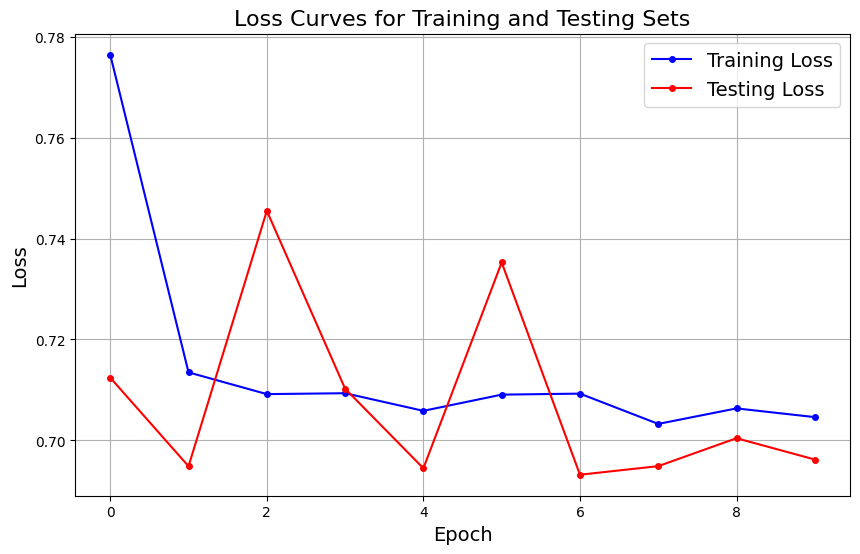

In [316]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_2")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with only two hidden layers may lack sufficient capacity to learn the complex patterns in the data, leading to high training loss and underfitting. Conversely, an excessively high capacity with multiple hidden layers may cause the model to overfit the training data, resulting in a low training loss but high test loss. Moreover, using Xavier or Glorot initialization for the weights instead of normal distribution initialization can enhance the model's learning capacity since the initialization helps to set the weights of the network to small random values that are inversely proportional to the square root of the number of input units in the previous layer. This ensures that the variance of the outputs of each layer remains consisten allowing gradients to flow through the network during backpropagation.


### Task 2: Data Preparation and Visualization

In [317]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [318]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [319]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    # set title for image with subplot

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 
    
    # Set a single title for the entire figure
    fig.suptitle('MNIST Dataset', fontsize=20)

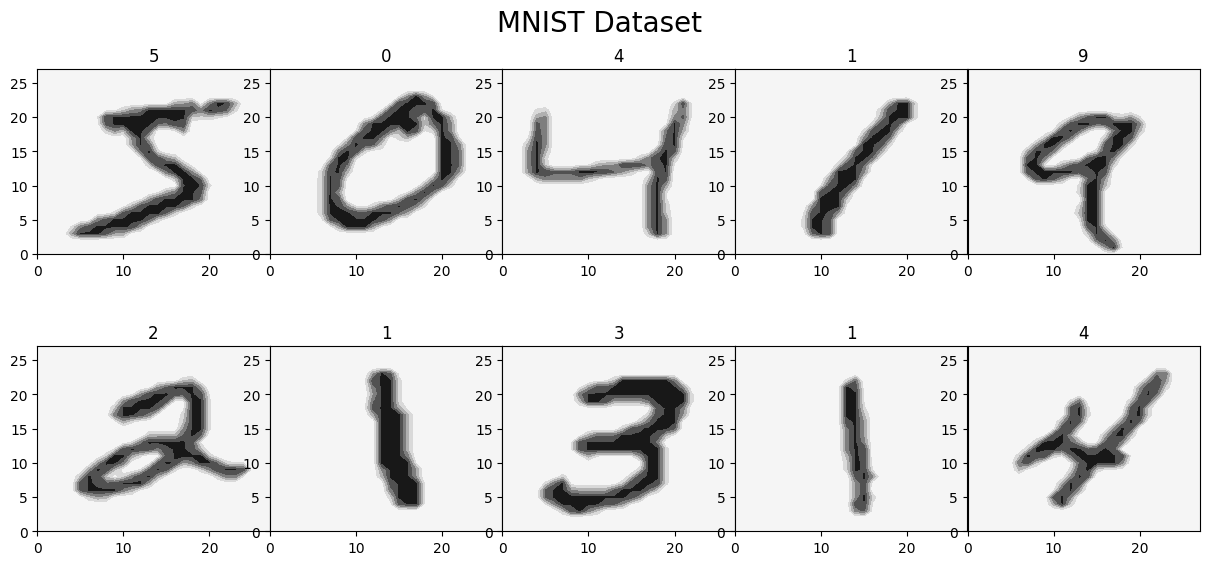

In [320]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [321]:
def plot_report(data: np.array) -> None:
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [322]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [323]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def normalise_data(data: np.array) -> np.array:
    """ Normalise vectors to be in a range of [-1, 1]
        Improves convergence of the model since gradients are in a similar range.
    """
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [324]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = normalise_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 87387.13it/s]


(1, 784)
(60000, 784)


In [325]:
plot_report(mnist_vectors)

Report for train set
Train Sum: -40993291.16078458
Train Min: -1.0
Train Max: -0.0039215686274509665
Train Mean: -0.8714560195745021
Train Shape: (60000, 784)
Train Datatype: float64


In [326]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


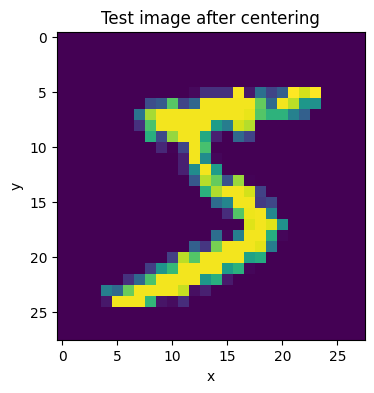

In [327]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [328]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    # the earlier eigenVectors have more information about the data
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [329]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 88169.93it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_2075/3987593753.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [330]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # Set a single title for the entire figure
    fig.suptitle('Selected MNIST Dataset Eigenvectors', fontsize=20)

    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

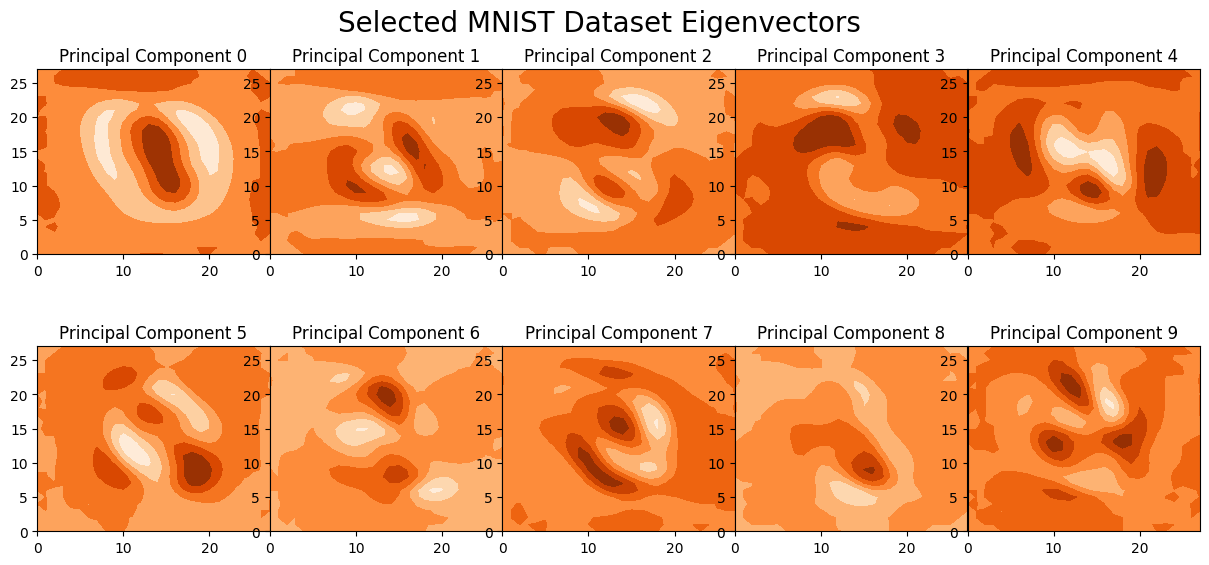

In [331]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plot visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [332]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [333]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return np.dot(x, y)

In [334]:
def plot_projection(sorted_eigenVectors, data, subset=None, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    if subset is None:
        N = len(list(data))
    else:
        N = subset

    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the first two vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

(2, 784)


100%|██████████| 60000/60000 [00:00<00:00, 91715.06it/s]


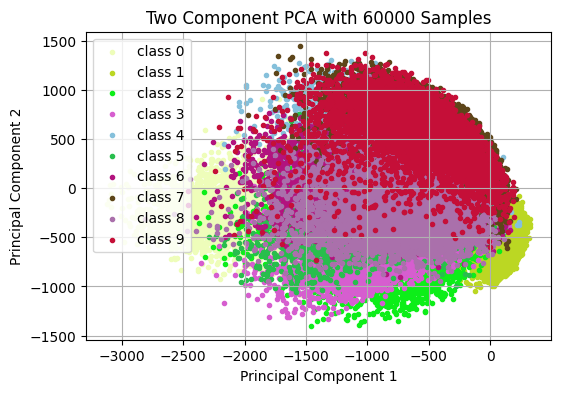

In [335]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs, we can already separate the images somehow 
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(sorted_eigenVectors=two_main_components, data=data_train)   

**Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?**

The diagram shows strong clusters and overlaps between the projected classes displaied, but little linear correlation within a class. Only very few classes can be separated, most are overlapping and mixed in the same PCA space. In this case, PCA may not well suited to capture non-linear relationships in a high-dimensional data set since it is itself a linear dimensionality reduction technique.

### Task 3: Defining, Training and Evaluating an MLP

In [336]:
# 1 build 5-layer MLP
class MultilayerPerceptron(nn.Module):
    """ The multilayer perceptron does a matrix multiplication of its 
        internal weights with the inputs and adds a bias in
        each layer. After that it activates the resulting vector.
        This can be done using the `Linear` layer. 
    """
    
    def __init__(self, size_hidden=100, size_out=10):
        """ Each hidden layer has 100 hidden units (output feature dimension).
            All hidden layers use ReLU activations.
        """
        super().__init__()
        # number of hidden nodes in each layer (100)
        # linear layer (784 -> hidden_1)
        self.fc1 = torch.nn.Linear(28*28, size_hidden) # Your Code here
        # linear layer (n_hidden -> n_hidden)
        self.fc2 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc3 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc4 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> size_out)
        self.out_layer = torch.nn.Linear(100, size_out)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # flatten the image, 
        # the -1 is a wildcard
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # flatten the output signal
        out = out.view(out.size(0), -1)
        out = self.out_layer(out)
        
        # no softmax as multi-class 
        # classification not probabilities

        return out

In [337]:
class MnistVectors(torch.utils.data.Dataset):
    ''' A Pytorch Dataset, which does the same 
        data preparation as was done in the PCA exercise.
    '''

    def __init__(self, split='train'):
        super().__init__()
        # torch dataset with casting operation
        mnist_train = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist_train)

            
    def __getitem__(self, idx):
        ''' Implements the ``[idx]`` method. Here we convert the numpy data to
            torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [338]:
# 3. Implement a function, which can report the accuracy of a batch of predictions in percent.

def batch_accuracy(prediction, label):
    """Uses labels to calculate the batch accuracy"""
    N = prediction.size(0)
    acc = prediction.eq(label.view_as(label)).sum().item()
    return (acc / N) * 100


def class_label(prediction):
    """ Transforms the output of the MultilayerPerceptron 
        into a scalar class label (index which matches predicted label: 0-9).
    """
    return prediction.argmax(dim=1)

def normalize_output(img):
    """ Normalizes the image to be in the range [0, 1]
        and converts it to a numpy array.
    """
    img = img - img.min()
    img = img / img.max()
    return img

In [339]:
# Visualize feature maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [340]:
# Visualize feature maps
act_fc1, act_fc2, act_fc3, act_fc4 = [], [], [], []
labels = []

In [341]:
def get_feature_maps(model, dataset=None, use_gpu=False):
    """ Get the feature maps of the model for a given dataset."""
    # define hook
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register hooks
    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    model.fc4.register_forward_hook(get_activation('fc4'))

    if not dataset:
        dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.ToTensor()
    )

    count = 0
    with torch.no_grad():
        for data_sample, label in dataset:
            
            data_sample = np.reshape(data_sample, -1)
            data_sample.unsqueeze_(0)

            if use_gpu:
                data_sample = data_sample.cuda()
                label = label.cuda()
                
            pred = model(data_sample)

            act1 = activation['fc1'].squeeze()
            act2 = activation['fc2'].squeeze()
            act3 = activation['fc3'].squeeze()
            act4 = activation['fc4'].squeeze()

            # collect activated feature maps
            act_fc1.append(act1.detach().cpu().numpy())
            act_fc2.append(act2.detach().cpu().numpy())
            act_fc3.append(act3.detach().cpu().numpy())
            act_fc4.append(act4.detach().cpu().numpy())

            # collect all labels
            labels.append(label)
            count += 1

        print(f" Done after {count} steps!")

In [342]:
def validate(test, model, criterion, use_gpu=False):
        test_accuracies = []
        test_losses = []
        
        model.eval()
        
        with torch.no_grad():
            for idx, [test_examples, test_labels] in enumerate(tqdm(test, desc='Test')):
                if use_gpu:
                    test_examples = test_examples.cuda()
                    test_labels = test_labels.cuda()
                
                test_prediction = model(test_examples)
                
                # evaluation
                test_loss = criterion(test_prediction, test_labels).data.item()
                test_acc = batch_accuracy(class_label(test_prediction), test_labels)

                if (idx % 10) == 0:
                    print('Test Batch Accuracy: {}%, Test Loss: {}'.format(test_acc, test_loss))
                
                test_accuracies.append(test_acc) # per batch
                test_losses.append(test_loss)

        # Use the batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

        print('Mean Validation Accuracy: {}%'.format(np.mean(test_accuracies)))
        print('Mean Validation Loss: {}%'.format(np.mean(test_losses)))

        plt.plot(test_accuracies)

In [343]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    model = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    
    Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
    testDl = DataLoader(TestData, batch_size=32, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?) 
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            
            optimizer.zero_grad()
            
            prediction = model(example)
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time to time.
            if (step % 375) == 0:
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        # checkpoints to reuse model weights
        torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

    # Now validate on the whole test set
    validate(testDl, model, criterion, use_gpu)

    # If you need to load the checkpoint instanciate your model and the
    # load the state dict from a checkpoint:
    # model = MultilayerPerceptron()
    # model.load_state_dict(torch.load(perceptron_3750.ckpt))
    # Make sure to use the latest checkpoint by entering the right number.

    ######################################
    ######      Code for task 4     ######
    ######################################

    get_feature_maps(model, use_gpu=use_gpu)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]   

Batch Accuracy: 9.375%, Loss: 3.392843723297119



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 87.5%, Loss: 0.48667365312576294



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 93.75%, Loss: 0.26691222190856934



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 93.75%, Loss: 0.14794456958770752



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 100.0%, Loss: 0.01111782155930996


Epoch:  20%|██        | 1/5 [00:02<00:08,  2.21s/it]

Batch Accuracy: 96.875%, Loss: 0.1622324287891388



Epoch:  20%|██        | 1/5 [00:02<00:08,  2.21s/it]      

Batch Accuracy: 96.875%, Loss: 0.20196692645549774



Epoch:  20%|██        | 1/5 [00:03<00:08,  2.21s/it]      

Batch Accuracy: 90.625%, Loss: 0.1831851452589035



Epoch:  20%|██        | 1/5 [00:03<00:08,  2.21s/it]       

Batch Accuracy: 90.625%, Loss: 0.2765499949455261



Epoch:  20%|██        | 1/5 [00:03<00:08,  2.21s/it]       

Batch Accuracy: 100.0%, Loss: 0.011522826738655567


Epoch:  40%|████      | 2/5 [00:04<00:06,  2.22s/it]

Batch Accuracy: 93.75%, Loss: 0.10253570973873138



Epoch:  40%|████      | 2/5 [00:04<00:06,  2.22s/it]      

Batch Accuracy: 96.875%, Loss: 0.06847169995307922



Epoch:  40%|████      | 2/5 [00:05<00:06,  2.22s/it]      

Batch Accuracy: 96.875%, Loss: 0.09352638572454453



Epoch:  40%|████      | 2/5 [00:05<00:06,  2.22s/it]       

Batch Accuracy: 90.625%, Loss: 0.3487038016319275



Epoch:  40%|████      | 2/5 [00:06<00:06,  2.22s/it]       

Batch Accuracy: 96.875%, Loss: 0.04577234014868736


Epoch:  60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

Batch Accuracy: 100.0%, Loss: 0.024135828018188477



Epoch:  60%|██████    | 3/5 [00:07<00:04,  2.22s/it]      

Batch Accuracy: 96.875%, Loss: 0.0684388279914856



Epoch:  60%|██████    | 3/5 [00:07<00:04,  2.22s/it]      

Batch Accuracy: 96.875%, Loss: 0.11540129780769348



Epoch:  60%|██████    | 3/5 [00:08<00:04,  2.22s/it]       

Batch Accuracy: 96.875%, Loss: 0.034847237169742584



Epoch:  60%|██████    | 3/5 [00:08<00:04,  2.22s/it]       

Batch Accuracy: 96.875%, Loss: 0.10789816826581955


Epoch:  80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

Batch Accuracy: 100.0%, Loss: 0.001682929927483201



Epoch:  80%|████████  | 4/5 [00:09<00:02,  2.26s/it]      

Batch Accuracy: 100.0%, Loss: 0.03088974580168724



Epoch:  80%|████████  | 4/5 [00:09<00:02,  2.26s/it]      

Batch Accuracy: 96.875%, Loss: 0.05317848175764084



Epoch:  80%|████████  | 4/5 [00:10<00:02,  2.26s/it]       

Batch Accuracy: 100.0%, Loss: 0.039583735167980194



Epoch:  80%|████████  | 4/5 [00:10<00:02,  2.26s/it]       

Batch Accuracy: 93.75%, Loss: 0.07566650211811066


Test: 100%|██████████| 313/313 [00:00<00:00, 2572.51it/s]


Test Batch Accuracy: 100.0%, Test Loss: 0.001980365253984928
Test Batch Accuracy: 93.75%, Test Loss: 0.16292062401771545
Test Batch Accuracy: 100.0%, Test Loss: 0.03443138673901558
Test Batch Accuracy: 96.875%, Test Loss: 0.08620262891054153
Test Batch Accuracy: 96.875%, Test Loss: 0.05658608675003052
Test Batch Accuracy: 90.625%, Test Loss: 0.3682611882686615
Test Batch Accuracy: 96.875%, Test Loss: 0.17620667815208435
Test Batch Accuracy: 100.0%, Test Loss: 0.006036379374563694
Test Batch Accuracy: 100.0%, Test Loss: 0.029480990022420883
Test Batch Accuracy: 96.875%, Test Loss: 0.08497095853090286
Test Batch Accuracy: 93.75%, Test Loss: 0.08151759207248688
Test Batch Accuracy: 96.875%, Test Loss: 0.6952553987503052
Test Batch Accuracy: 90.625%, Test Loss: 0.2670689821243286
Test Batch Accuracy: 93.75%, Test Loss: 0.17243115603923798
Test Batch Accuracy: 96.875%, Test Loss: 0.13254967331886292
Test Batch Accuracy: 90.625%, Test Loss: 0.32580816745758057
Test Batch Accuracy: 100.0%, Te

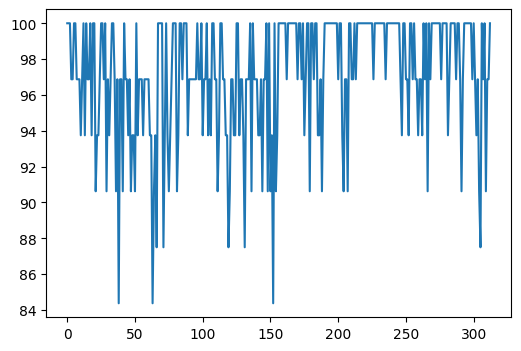

In [344]:
train(use_gpu=True if torch.cuda.is_available() else False)

#### Task 4: Visualizing MLP Features

In [345]:
# 1. MNIST images of the test split, or if you have limited computational resource for a subset of at least 1000 image
print(np.asarray(act_fc1).shape)

(10000, 100)


In [346]:
# 2. find PCA of vectors and project feature maps onto the first two principal components
def convert_act_to_vectors(data):
    '''Converts the activated feature maps to vectors of size ``[n*m]``.
       It outputs mnist_vectors as a array with the shape of [N, n*m], where
       N is the number of maps in data.
    '''

    act_vectors = []

    for act in tqdm(data):
        act_array = np.asarray(act)
        act_array = np.reshape(act_array, -1) # reshape array to vector
        act_vectors.append(act_array)
    
    # return as numpy arrays
    return norm_data(np.array(act_vectors))

In [347]:
def do_pca_actm(data):
    '''Returns matrix [nxm] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
       >>> PCA compresses the input data into its representation.
    '''

    actm_vectors = convert_act_to_vectors(data)
    # prepare_data(actm_vectors)

    # compute covariance matrix of data
    cov = np.cov(actm_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues descending
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    
    return sorted_eigenVectors.astype(np.float64).T

In [348]:
pca_act_fc1 = do_pca_actm(act_fc1)
pca_act_fc2 = do_pca_actm(act_fc2)
pca_act_fc3 = do_pca_actm(act_fc3)
pca_act_fc4 = do_pca_actm(act_fc4)

print(pca_act_fc1.shape)
print(pca_act_fc2.shape)
print(pca_act_fc3.shape)
print(pca_act_fc4.shape)

100%|██████████| 10000/10000 [00:00<00:00, 1339947.61it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 299605.98it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 333320.41it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 128297.57it/s]


<class 'numpy.ndarray'> (100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


(2, 100)
labels: 10000


10000it [00:00, 761825.05it/s]


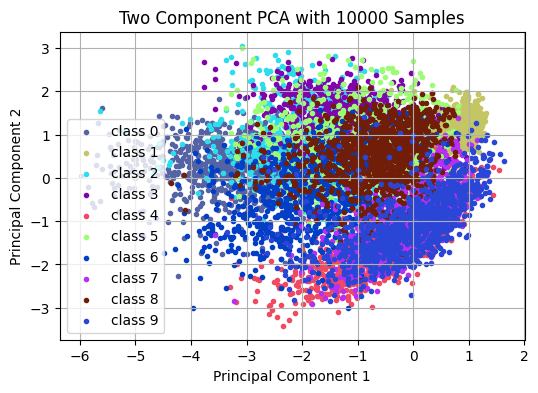

In [349]:
# 3. Make a scatter plot of the projected feature maps onto the first two principal components
# find the two main important PCs
two_main_components = pca_act_fc1[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc1, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1285058.98it/s]


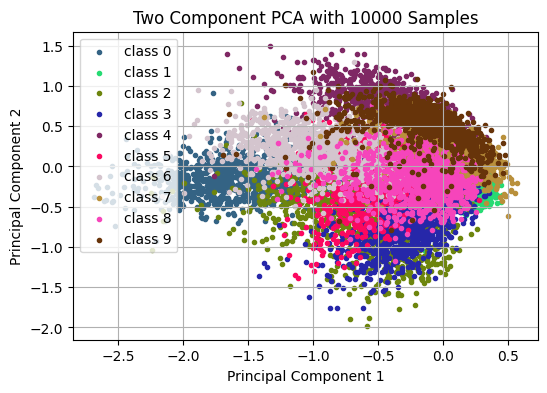

In [350]:
# find the two main important PCs
two_main_components = pca_act_fc2[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc2, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1291827.03it/s]


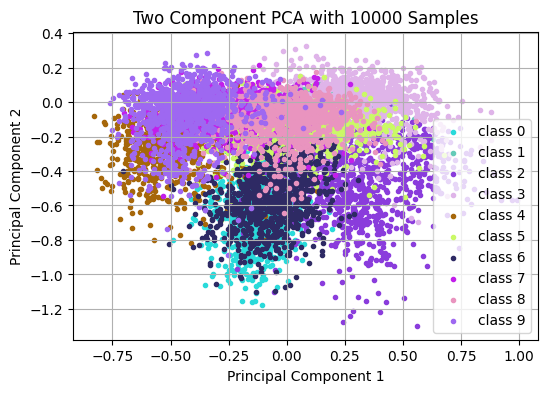

In [351]:
# find the two main important PCs
two_main_components = pca_act_fc3[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc3, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1281055.56it/s]


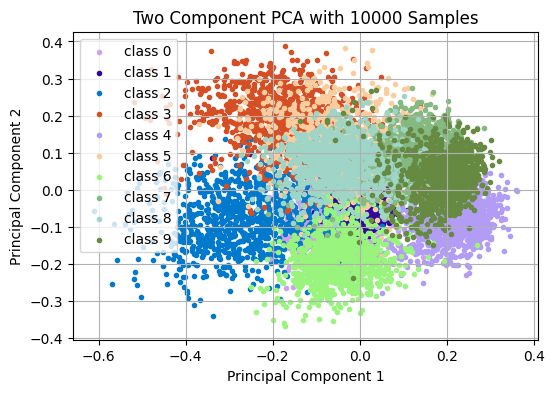

In [352]:
# find the two main important PCs
two_main_components = pca_act_fc4[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc4, labels), subset=len(labels))

**Compare the plots to the scatter plot from task 2. What has changed, what is similar?**

The PCA plots show a progressive scattering of salient features along the x- and y-axis through the model layers, indicating a more linear correlation within classes. However, the overlap of features in classes persists, and the variance within classes remains high. The scatter plot from task 2 also showed high variance and overlap, but the PCA plots reveal a more structured distribution of features, particularly in later layers. Thereby, the MNIST digit classification challenge can be understood as difficult due to the high variance within classes and the lack of linear separability between them.

**Do you believe that the MLP is a suitable method for MNIST digit classification? Provide an explanation.**

MLPs are relatively simple and suitable for structured data, making them a good baseline model for MNIST digit classification. However, CNNs are better suited for processing large image datasets as they can capture spatial relationships between pixels and develop an internal representation of the training dataset. CNNs also use weight sharing, making them more parameter-efficient than MLPs. Therefore, while an MLP can be used as a starting point, a CNN is likely to achieve better performance on the MNIST dataset.
